In [2]:
import numpy as np
import pylab as plt
import sounddevice as sd
from scipy import signal as sg
import seaborn as sns
from ipywidgets import interactive

plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150
plt.rcParams['axes.grid'] = True

# 0. Повторение
### Линейная стационарная система
Система $S$ называется линейной стационарная системой (LTI) если:
> 1. $S(a_1x_1[n] + a_2x_2[n]) = a_1S(x_1[n]) + a_2S(x_2[n])$
> 2. $y[n] = S(x[n]) \Rightarrow S(x[n-n_0]) = y[n-n_0]$, $\forall n_0: -\infty < n_0 < \infty$

Напоминание: 
> $x[n] = \sum_{k=-\infty}^\infty x[k]\delta[n-k]$

Пусть $S$ - LTI. Тогда:

> $y[n] = S(x[n]) = S\Big(\sum_{k=-\infty}^\infty x[k]\delta[n-k]\Big) = $

> $ = \sum_{k=-\infty}^\infty x[k]S(\delta[n-k]) = $

> $ = \sum_{k=-\infty}^\infty x[k]h[n-k]$

Свертка:

> $ y[n] = x[n]\star h[n]$

$h[n]$ - *импульсная характеристика системы*

$\star$ - *операция свертки*

#### Примеры

###### Идеальная система задержки:
> $y[n] = S_d(x[n]) = x[n-d]$

> $h[n] = S(\delta[n]) = \delta[n-d]$

> $y[n] = x[n] \star h[n] = \sum_{k=-\infty}^\infty x[k]h[n-k] = $

> $ = \sum_{k=-\infty}^\infty x[k]\delta[n-d-k] = x[n-d]$

###### Скользящее среднее 

> $y[n] = S(x[n]) = \frac{1}{3}\sum_{k=-1}^{1}x[n-k]$

> $h[n] = S(\delta[n]) = \frac{1}{3}\sum_{k=-1}^{1}\delta[n-k] = \frac{1}{3}\delta[n-1] + \frac{1}{3}\delta[n] + \frac{1}{3}\delta[n+1] $

> $y[n] = x[n]\star h[n] = \sum_{k=-\infty}^\infty x[k]h[n-k] =$

> $= \sum_{k=-\infty}^\infty x[k](\frac{1}{3}\delta[n-1-k] + \frac{1}{3}\delta[n-k] + \frac{1}{3}\delta[n+1-k]) = $

> $= \frac{1}{3}x[n-1] + \frac{1}{3}x[n] + \frac{1}{3}x[n+1]= \frac{1}{3}\sum_{k=-1}^{1}x[n-k]$

# 1. Свойства LTI систем
LTI система полностью описывается импульсной характеристикой $h[n]$


$y[n] = S\Big(x[n]\Big) = x[n]\star h[n] = \sum\limits_{k=-\infty}^\infty x[k]\cdot h[n-k] $

In [21]:
def pad(domain, n, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start:start+len(domain)] = domain
    return x

def pad_reverse_and_shift(domain, n, shift=0, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start-len(domain)+1+shift:start+1+shift] = domain[::-1]
    return x
        
    

n = np.arange(-5, 10)
x_domain = [-1, -0.5, 0, 0.5, 1]
h_domain = [1, -1]


def plot_conv(m=-3):
    x = pad(x_domain, n)
    h = pad(h_domain, n)
    h_nmk = pad_reverse_and_shift(h_domain, n, m)
    y = np.convolve(pad(x_domain, n), h_domain, 'same')

    fig, axes = plt.subplots(3, figsize=(8, 6), sharex='all', sharey='all')
    axes[1].plot(n+0.05, x, 'oC0', label='$x[k]$')
    axes[0].plot(n+0.05, x, 'oC0', label='$x[n]$')
    axes[0].plot(n-0.05, h, 'oC1', label='$h[n]$')
    axes[1].plot(n-0.05, h_nmk, 'oC3', label='$h[{}-k]$'.format(m))
    axes[1].plot(n, h_nmk*x, 'xk', label='$x[k]\cdot h[{}-k]$'.format(m), markersize=4)
    axes[2].plot(n, y, 'oC2', label='$y[n]$')
    axes[2].plot(m, sum(x*h_nmk), 'xC3', label='$y[{}]$'.format(m), markersize=10)
    axes[0].legend(loc=4), axes[1].legend(loc=4), axes[2].legend(loc=4) 
    [ax.axvline(m, zorder=-100, color='k', alpha=0.5, linestyle='--') for ax in axes]
    sns.despine()
    plt.show()


interactive_plot = interactive(plot_conv, m=(-3, 7, 1))
output = interactive_plot.children[-2]
interactive_plot

interactive(children=(IntSlider(value=-3, description='m', max=7, min=-3), Output()), _dom_classes=('widget-in…


## Свойства свертки:

1. Коммутативность $a[n]\star b[n]=b[n]\star a[n]$. 
2. Дистрибутивность $x[n]\star \Big(h_1[n] + h_2[n]\Big)$
3. Ассоциативность $\Big(x[n]\star h_1[n]\Big)\star h_2[n] = x[n]\star \Big(h_1[n]\star h_2[n]\Big)$


## Комбинация LTI систем
Как следствие последовательность применения LTI систем не важна:

> $y_1[n] = S_{1}\Big(x[n]\Big) = x[n]\star h_1[n]$

> $y_2[n] = S_{2}\Big(y_1[n]\Big) = y_1[n]\star h_2[n]$

> $y_2[n] = \Big(x[n]\star h_1[n]\Big)\star h_2[n] = x[n]\star \Big(h_1[n]\star h_2[n]\Big) = x[n]\star \Big(h_2[n]\star h_1[n]\Big) = \Big(x[n]\star h_2[n]\Big)\star h_1[n]$

### Вопрос

Как связана испульсная характеристика $h_{12}[n]$ системы $y_2[n] = S_{12}\Big(x[n]\Big) = S_{2}\Big(S_1(x[n])\Big)$ с испульсными характеристиками $h_1[n]$ и $h_2[n]$?

.

.

.

*Ответ:* 

> $h_{12}[n] = h_{1}[n]\star h_{2}[n]$




### Пример

1. Идеальная система задержки на 2 отсчета: $$h_1[n] = \delta[n-2]$$

2. Скользящее среднее с симметричным окном в 3 отсчета: $$h_2[n] = \frac{1}{3}\Big(\delta[n-1] + \delta[n] + \delta[n+1]\Big) $$

Комбинация систем 1 и 2:

$h_{12} = h_{2}[n]\star h_{1}[n] = \frac{1}{3}\Big(\delta[n-1] + \delta[n] + \delta[n+1]\Big) \star \delta[n-2]$

$h_{12} = \sum\limits_{k=-\infty}^\infty \frac{1}{3}\Big(\delta[k-1] + \delta[k] + \delta[k+1]\Big)\cdot \delta[n-2-k]$

$h_{12} = \frac{1}{3}\Big(\delta[n-3] + \delta[n-2] + \delta[n-1]\Big)$

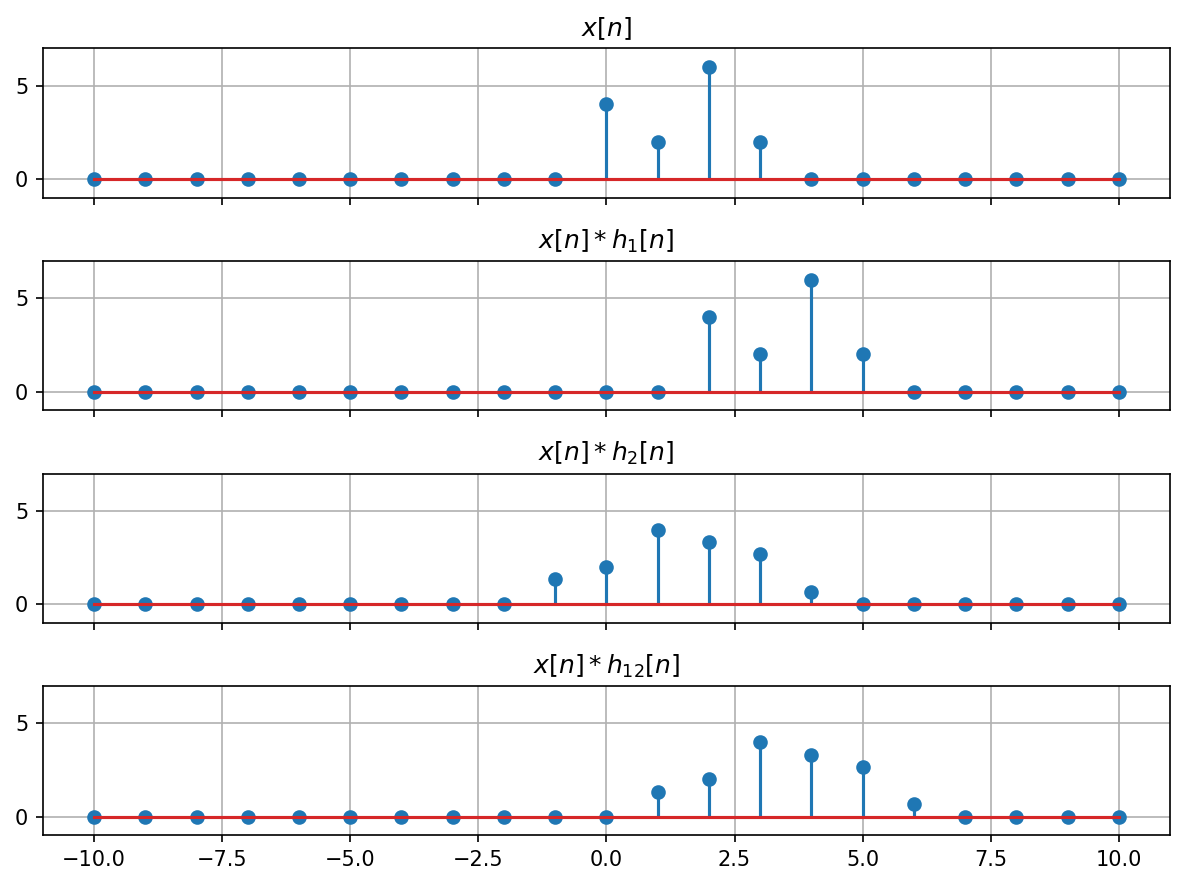

In [22]:
import pylab as plt
import numpy as np


n = np.arange(-10, 11)

x = np.zeros(len(n))
x[np.in1d(n, [0, 1, 2, 3])] = [4, 2, 6, 2]

h1 = (n-2==0)
h2 = (n-1==0).astype(int)/3 + (n==0).astype(int)/3 + (n+1==0).astype(int)/3


fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=(8,6))

ax[0].stem(n, x, use_line_collection=True)
ax[0].set_title('$x[n]$')

ax[1].stem(n, np.convolve(x, h1,'same'), use_line_collection=True)
ax[1].set_title('$x[n]*h_1[n]$')

ax[2].stem(n, np.convolve(x, h2,'same'), use_line_collection=True)
ax[2].set_title('$x[n]*h_2[n]$')

ax[3].stem(n, np.convolve(np.convolve(x, h1,'same'), h2, 'same'), use_line_collection=True)
ax[3].set_title('$x[n]*h_{12}[n]$')

plt.ylim(-1, 7)
plt.tight_layout()

# 2. Проверка устойчивости (stable)

Напоминание: система устойчива если для любой ограниченной входной последовательности

$|x[n]| \le B_x <\infty$ $\forall n $

Выходная последовательность ограничена

$|y[n]| \le B_y <\infty$ $\forall n $

### Для LTI системы:
$|y[n]| = \Big|x[n]\star h[n] \Big| = \Big|\sum\limits_{k=-\infty}^\infty x[k]\cdot h[n-k] \Big| \le 
\sum\limits_{k=-\infty}^\infty |x[k]|\cdot |h[n-k]| \le $

$ \le B_x\sum\limits_{k=-\infty}^\infty |h[n-k]|  $

$\sum\limits_{k=-\infty}^\infty |h[n-k]| < \infty$

### Примеры:

*Скользящее среднее - устойчива*

$h[n] = \frac{1}{3}\Big(\delta[n-1] + \delta[n] + \delta[n+1]\Big) $

$\sum\limits_{k=-\infty}^\infty |h[n-k]| = \sum\limits_{k=-\infty}^\infty \Big| \frac{1}{3}\Big(\delta[k-1] + \delta[k] + \delta[k+1]\Big) \Big| = 1$

*Сумматор - НЕустойчив*

$y[n] = \sum\limits_{k=-\infty}^{n}x[k]$


$h[n] = S\big(\delta[n]\big) = \sum\limits_{k=-\infty}^{n}\delta[k] = u[n]$

$h[n] = u[n]$

$\sum\limits_{k=-\infty}^\infty |u[n-k]| = \infty $

### Вопрос:
Рассмотрим LTI систему с испульсной характеристикой:

$h[n] = a^n\cdot u[n]$

При каких $a$ данная система устойчива? 

.

.

.

$\sum\limits_{k=-\infty}^\infty |a^n|\cdot |u[n-k]| = \sum\limits_{k=0}^\infty |a|^n$

При $|a|<1$:

$\sum\limits_{k=-\infty}^\infty |a|^n = \frac{1}{1-|a|} < \infty$

# 3. Представление LTI системы в виде разностной схемы

Некоторые LTI системы могут быть заданы следующим уравнением:

$\sum\limits_{k=0}^K a_k\cdot y[n-k] = \sum\limits_{m=0}^M b_m\cdot x[n-m]$

## Примеры

### Скользящее среднее по 3 последним отсчетам

$y[n] = \frac{1}{3}\Big(x[n] + x[n-1] + x[n-2]\Big)$


$a_0 = 1$

$b_0=b_1=b_2 = \frac{1}{3}$



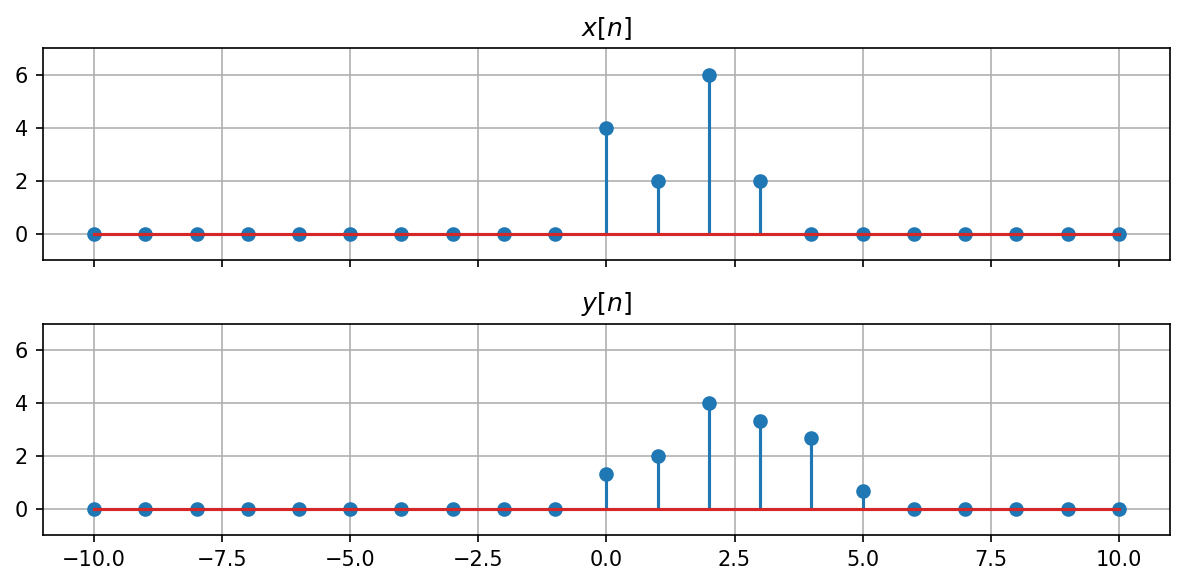

In [23]:
from scipy import signal
y = signal.lfilter(b=[1/3, 1/3, 1/3], a=[1], x=x)

fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(8,4))

ax[0].stem(n, x,  use_line_collection=1)
ax[0].set_title('$x[n]$')

ax[1].stem(n, y,  use_line_collection=1)
ax[1].set_title('$y[n]$')


plt.ylim(-1, 7)
plt.tight_layout()

### Экспоненциальный сглаживатель
$y[n] = \beta \cdot y[n-1] + (1-\beta) \cdot x[n]$ 

$\beta \in [0,1] $ - коэффициент сглаживания


В виде разностной схемы:

$y[n] - \beta \cdot y[n-1] = (1-\beta) \cdot x[n] $ 

$a_0 = 1$

$a_1 = -\beta$

$b_0=1-\beta$

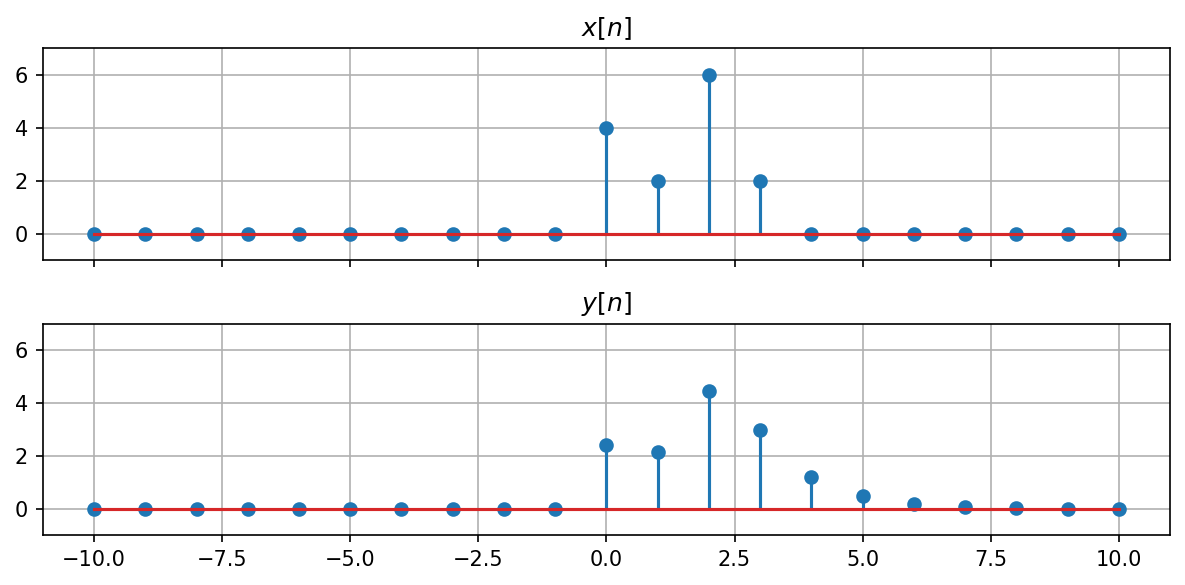

In [24]:
beta=0.4
y = signal.lfilter(b=[1-beta], a=[1, -beta], x=x)

fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(8,4))

ax[0].stem(n, x, use_line_collection=1)
ax[0].set_title('$x[n]$')

ax[1].stem(n, y, use_line_collection=1)
ax[1].set_title('$y[n]$')


plt.ylim(-1, 7)
plt.tight_layout()

### Сумматор

$y[n] = \sum\limits_{k=-\infty}^{n}x[k]$

$y[n] = x[n] + \sum\limits_{k=-\infty}^{n-1}x[k] = x[n] + y[n-1]$

$y[n] - y[n-1] = x[n]$

$a_0 = 1$ 

$a_1 = -1$ 

$b_0 = 1$

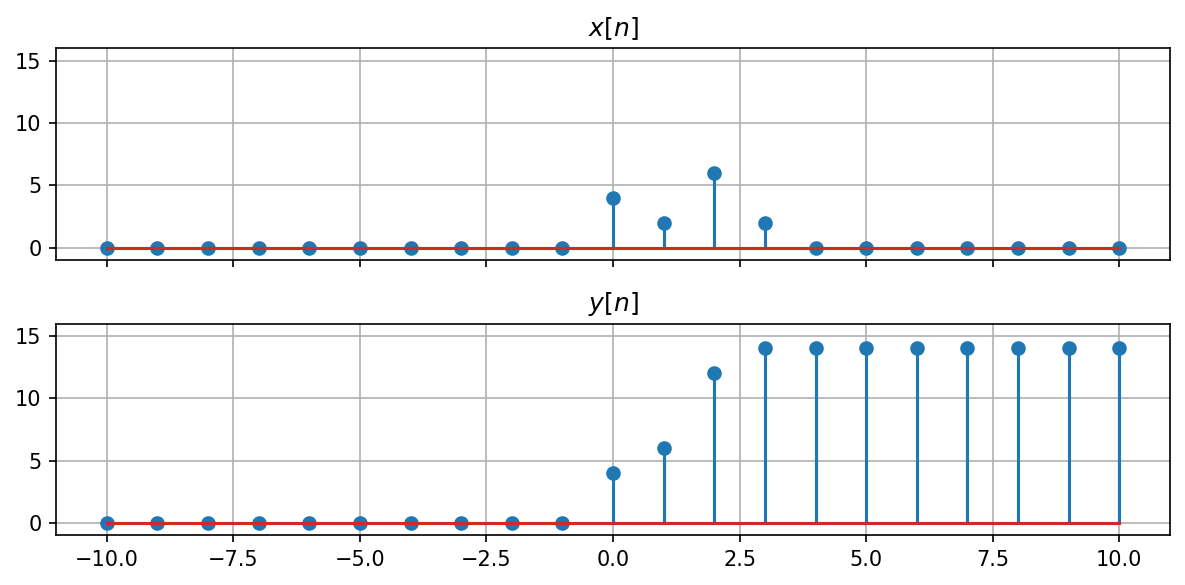

In [25]:
from scipy import signal
y = signal.lfilter(b=[1], a=[1, -1], x=x)

fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 4))

ax[0].stem(n, x, use_line_collection=1)
ax[0].set_title('$x[n]$')

ax[1].stem(n, y, use_line_collection=1)
ax[1].set_title('$y[n]$')


plt.ylim(-1, 16)
plt.tight_layout()

# 4. Комплексная частотная характеристика LTI системы

> $x[n] = e^{jwn}$ - "гармоника" с частотой $w$

> $y[n] = h[n]*x[n] = \sum\limits_{k=-\infty}^\infty h[k]\cdot x[n-k]$

> $y[n] = h[n]*(e^{jwn}) = \sum\limits_{k=-\infty}^\infty h[k]\cdot e^{jw(n-k)} = \Big(\sum\limits_{k=-\infty}^\infty h[k]\cdot e^{-jwk} \Big) e^{jwn}$

> $ H(e^{jw}) = \sum\limits_{k=-\infty}^\infty h[k]\cdot e^{-jwk}$ - комплексная частотная характеристика

> $y[n] = H(e^{jw})\cdot e^{jwn}$

## АЧХ и ФЧХ

> $ A(e^{jw}) = |H(e^{jw})| $ - амплитудо-частотная характеристика (АЧХ)

> $ \phi(e^{jw}) = \angle H(e^{jw}) $ - фазо-частотная характеристика (ФЧХ)

## АЧХ скользящего среднего

> $y[n] = S(x[n]) = \frac{1}{2M + 1}\sum\limits_{m=-M}^{M}x[n-m]$

> $h[n] = S(\delta[n]) = \frac{1}{2M + 1}\sum\limits_{m=-M}^{M}\delta[n-m]$

> $H(e^{jw}) = \sum\limits_{k=-\infty}^\infty h[k]\cdot e^{-jwk} = \sum\limits_{k=-\infty}^\infty \frac{1}{2M + 1} \sum\limits_{m=-M}^{M}\delta[k-m]\cdot e^{-jwk} $

> $= \frac{1}{2M + 1} \sum\limits_{m=-M}^{M} \sum\limits_{k=-\infty}^\infty\delta[k-m]\cdot e^{-jwk} = \frac{1}{2M + 1} \sum\limits_{m=-M}^{M}e^{-jwm}$

> $H(e^{jw}) = \frac{1}{2M + 1} \sum\limits_{m=-M}^{M}e^{-jwm} = \frac{1}{2M + 1} \sum\limits_{m=0}^{2M}e^{-jw (m -M)}$

> $H(e^{jw}) = \frac{1}{2M + 1} \frac{sin\big(w(2M+1)/2\big)}{sin(w/2)}$

> $ M = 1$

> $H(e^{jw}) = \frac{1}{3} \frac{sin\big(w3/2\big)}{sin(w/2)}$

> $A(e^{jw}) = |H(e^{jw})| = \Big|\frac{1}{3} \frac{sin(3w/2)}{sin(w/2)}\Big|$

In [26]:
def plot_ac(M=1):
    w = np.linspace(-np.pi*3, np.pi*3, 10000)
    H = np.abs(np.sin(w*(2*M+1)/2)/np.sin(w/2)/(2*M+1))

    plt.plot(w, H)
    plt.ylabel('$A(e^{jw})$')
    plt.xlabel('w')
    plt.xlim(-np.pi, np.pi)
    plt.show()

interactive_plot = interactive(plot_ac, M=(1, 20, 1))
output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='M', max=20, min=1), Output()), _dom_classes=('widget-int…

### Задача: 
Найти минимальное значение параметра сглаживания $M$, такое чтобы амплитуда гармонических последовательностей с частотой $w>0.2$ проходящих через скользящее среднее сокращалась на 50% и более.

In [27]:


def plot_ac(M=1, w0=0.1):
    fig, axes = plt.subplots(2, figsize=(8, 4))
    H_func = lambda w: np.abs(np.sin(w*(2*M+1)/2)/np.sin(w/2)/(2*M+1))
    
    w = np.linspace(-np.pi*3, np.pi*3, 10000)
    H = H_func(w)

    axes[0].plot(w, H)
    axes[0].set_ylabel('$A(e^{jw})$')
    axes[0].set_xlabel('w')
    axes[0].set_xlim(-np.pi, np.pi)
    axes[0].axvline(w0*np.pi, color='k')
    
    Hpi16 = H_func(np.pi*w0)
    axes[0].plot(np.pi*w0, Hpi16, 'k.-')
    axes[0].text(np.pi*w0, Hpi16, '{:.2f}'.format(Hpi16))
    
    
    
    
    n = np.arange(-20, 20)

    h = np.zeros(len(n))
    h[np.abs(n)<=M] = 1/(1+2*M)

    w = np.pi*w0
    x = np.sin(w*n)
    y = np.convolve(x, h, 'same')

    axes[1].plot(n, x, 'o', label='$x[n] = e^{-jnw_0}$'+f', $w_0$={w0:.2f}')
    axes[1].plot(n, y,'xC3', label='$y[n]$')
    axes[1].set_ylabel('$y[n]$')
    axes[1].set_xlabel('$n$')
    axes[1].axhline(0.5, color='g')
    axes[1].axhline(-0.5, color='g')
    axes[1].legend(loc=3)
    fig.subplots_adjust(hspace=0.3)
    plt.show()


#     plt.ylim(-1.6, 1.6)

interactive_plot = interactive(plot_ac, M=(1, 20, 1), w0=(0.1, 1, 0.1))
output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='M', max=20, min=1), FloatSlider(value=0.1, description='…